In [1]:
import os
import sys
import pathlib
# import argparse

sys.path.append('/home/psimmerl/mds_analysis')

import math
import numpy as np
# import numba as nb
from math import ceil, floor

# from src.helper_functions import alert, Table
# from src.histo_utilities import std_color_list as SCL

from src import CMS_lumi, tdrstyle
root_style = tdrstyle.setTDRStyle()

import ROOT as rt
from ROOT import RDataFrame
# from ROOT import TNtuple, TTree, TBranch, RDataFrame
from ROOT import TCanvas, TLatex, TLegend, TLine, TBox
from ROOT import TH1D, TH2D, TGraph, TGraphErrors, TGraphAsymmErrors

# **************************** #
OUT_DIR = 'reports/weekly/2024-01-22'
LOCAL_OUT_DIR = '/home/psimmerl/mds_analysis'  # os.getcwd()

DATA_VERSION = '6'
LUMI = 23.02 * 1000
PI = rt.TMath.Pi()

LOCAL_DATA_DIR = '/home/psimmerl/mds_analysis/data'  # os.getcwd() + '/data/raw'
DATA_DIR = 'TIER2' if 'caltech' in os.uname()[1] else 'LOCAL'
OUT_DIR = f'{LOCAL_OUT_DIR}/{OUT_DIR}'

FN_MC = f'{LOCAL_DATA_DIR}/processed/mc_rdf.root'
FN_R3 = f'{LOCAL_DATA_DIR}/processed/r3_rdf.root'

pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

ROOT_ERROR_LEVEL = 1001  # rt.kInfo + 1
rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL

SCL = [1, 2, 4, 8, 6, 28, 43, 7, 25, 36, 30, 40, 42, 49, 46, 38, 32, 800, 600, 900, 870, 840]

gc = []

# **************** #

rdfs = {
    'mc' : RDataFrame('MuonSystem_flat', FN_MC),
    'r3' : RDataFrame('MuonSystem_flat', FN_R3),
}

print('Events Read:')
for key, rdf in rdfs.items():
    count, weight = rdf.Count().GetValue(), rdf.Sum('weight').GetValue()
    print(f'  {key} = {count:,} ({weight:,.2f})')
print('')

Welcome to JupyROOT 6.30/02
Events Read:
  mc = 1,613 (974.40)
  r3 = 83 (83.00)



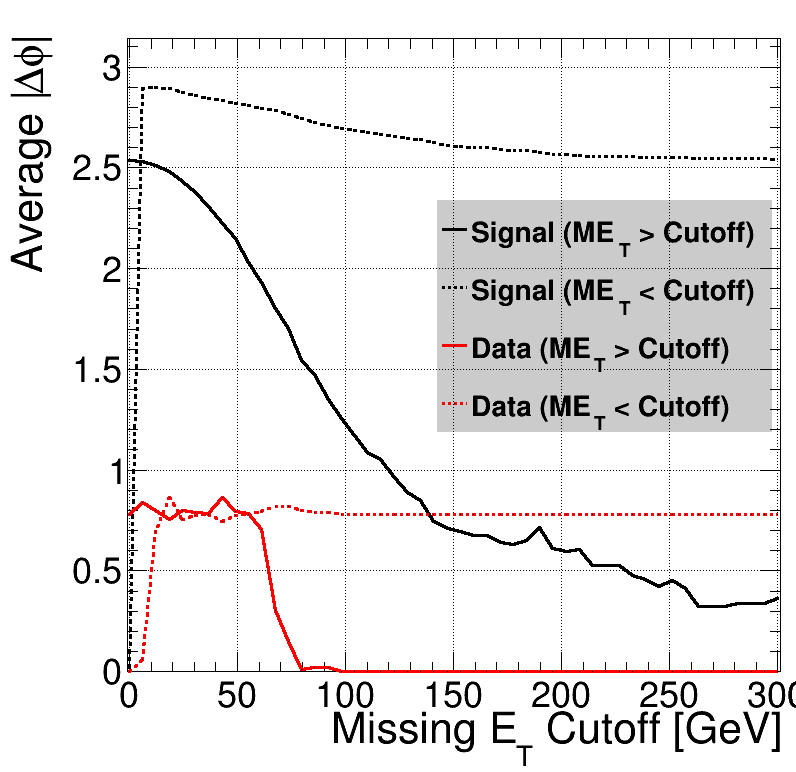

In [33]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()

legend = TLegend(0.55, 0.44, 0.97, 0.74)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.1)

mets = np.linspace(0,300,50)
dphiA_mc = np.array([m.GetValue() for m in [rdfs['mc'].Filter(f'met > {met}').Mean('tag_dPhi') for met in mets]])
dphiA_r3 = np.array([m.GetValue() for m in [rdfs['r3'].Filter(f'met > {met}').Mean('tag_dPhi') for met in mets]])
dphiB_mc = np.array([m.GetValue() for m in [rdfs['mc'].Filter(f'met < {met}').Mean('tag_dPhi') for met in mets]])
dphiB_r3 = np.array([m.GetValue() for m in [rdfs['r3'].Filter(f'met < {met}').Mean('tag_dPhi') for met in mets]])

# **** #
values, ylabel = [dphiA_mc,dphiB_mc,dphiA_r3,dphiB_r3], 'Average |#Delta#phi|'

xlabel = 'Missing E_{T} Cutoff [GeV]'
names = ['Signal (ME_{T} > Cutoff)', 'Signal (ME_{T} < Cutoff)', 'Data (ME_{T} > Cutoff)', 'Data (ME_{T} < Cutoff)']
hmin, hmax = 0, PI
for igr, val in enumerate(values):
    gr = TGraph(len(mets),mets,val)
    gr.GetXaxis().SetLimits(np.min(mets)-1, np.max(mets)+1)
    gr.SetMinimum(hmin)
    gr.SetMaximum(hmax)
    gr.SetName(names[igr])
    gr.GetXaxis().SetTitle(xlabel)
    gr.GetYaxis().SetTitle(ylabel)

    gr.SetLineWidth(3)
    gr.SetLineColor(SCL[0 if 'Signal' in names[igr] else 1])
    gr.SetLineStyle(rt.kDashed if '<' in names[igr] else rt.kSolid)
    gr.Draw(('' if igr else 'A')+' LP')
    legend.AddEntry(gr,gr.GetName(),'LP')
    gc.append(gr)

legend.Draw()
canvas.Draw()


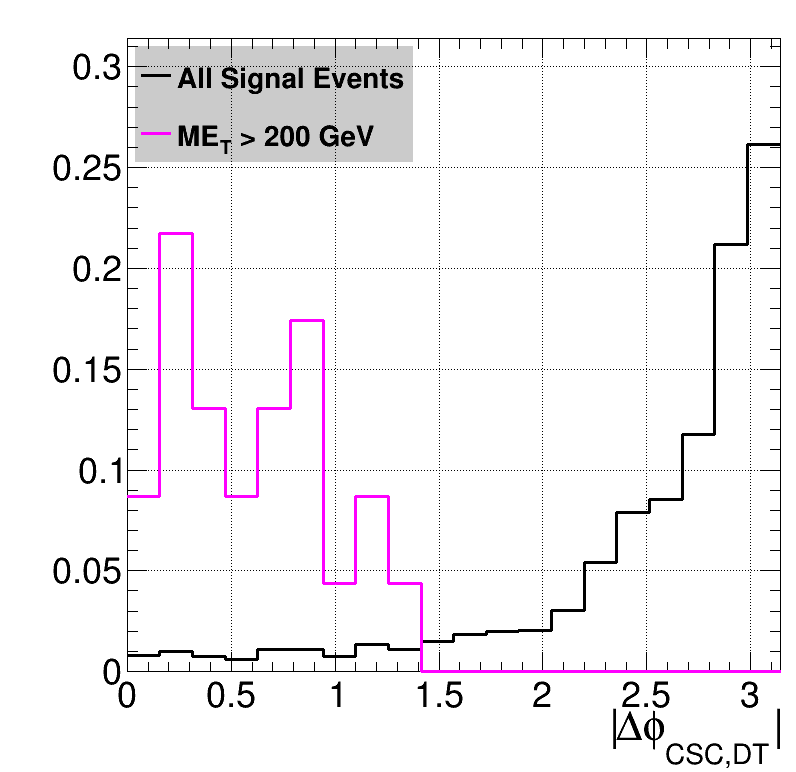

In [36]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()

legend = TLegend(0.17, 0.79, 0.52, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.15)

xv = 'tag_dPhi'

h1 = rdfs['mc'].Histo1D(('',';|#Delta#phi_{CSC,DT}|;',20,0,PI),xv).GetValue()
hmax = h1.GetMaximum()

h1.SetMinimum(0)
h1.SetMaximum(1.2*hmax)
h1.SetLineColor(SCL[0])
h1.SetLineWidth(3)
h1.DrawNormalized()
legend.AddEntry(h1, 'All Signal Events', 'L')

h2 = rdfs['mc'].Filter('met>200').Histo1D(('',f';{xv};',20,0,PI),xv).GetValue()
h2.SetMinimum(0)
h2.SetMaximum(1.2*hmax)
h2.SetLineColor(SCL[4])
h2.SetLineWidth(3)
h2.DrawNormalized('same')
legend.AddEntry(h2, 'ME_{T} > 200 GeV', 'L')

# mets = np.linspace(0,100,50)
# dphi_mc = np.array([m.GetValue() for m in [rdfs['mc'].Filter(f'met > {met}').Mean('tag_dPhi') for met in mets]])
# dphi_r3 = np.array([m.GetValue() for m in [rdfs['r3'].Filter(f'met > {met}').Mean('tag_dPhi') for met in mets]])

# # **** #
# values, ylabel = [dphi_mc,dphi_r3], 'Average |#Delta#phi|'

# xlabel = 'Minimum Missing E_{T} [GeV]'
# names = ['Signal', 'Data']
# hmin, hmax = 0, PI
# for igr, val in enumerate(values):
#     gr = TGraph(len(mets),mets,val)
#     gr.GetXaxis().SetLimits(np.min(mets)-1, np.max(mets)+1)
#     gr.SetMinimum(hmin)
#     gr.SetMaximum(hmax)
#     gr.SetName(names[igr])
#     gr.GetXaxis().SetTitle(xlabel)
#     gr.GetYaxis().SetTitle(ylabel)

#     gr.SetLineWidth(3)
#     gr.SetLineColor(SCL[igr])
#     gr.Draw(('' if igr else 'A')+' LP')
#     legend.AddEntry(gr,gr.GetName(),'LP')
#     gc.append(gr)

legend.Draw()
canvas.Draw()


In [45]:
MAKE_DATACARDS = True

def calc_abcd(rdf, dphi_cond, size_cond, dphi_flip):
    dphi_cond, size_cond = f'tag_dPhi {"<" if dphi_flip else ">"} {dphi_cond}', f'dtSize > {size_cond}'
    a = rdf.Filter(f'({dphi_cond}) && ({size_cond})').Sum('weight')
    b = rdf.Filter(f'({dphi_cond}) && !({size_cond})').Sum('weight')
    c = rdf.Filter(f'!({dphi_cond}) && !({size_cond})').Sum('weight')
    d = rdf.Filter(f'!({dphi_cond}) && ({size_cond})').Sum('weight')
    return [a,b,c,d]#[x.GetValue() for x in (a, b, c, d)]

met_abcds = {}
if MAKE_DATACARDS:
    rdf_mc, rdf_r3 = rdfs['mc'], rdfs['r3']

    abcd_mc, abcdL_mc, abcdH_mc, abcd_r3, abcdL_r3, abcdH_r3 = [],[],[],[],[],[]#(np.zeros((met_dphi_size_grid.shape[0],4)) for i in range(4))

    # met_dphi_size_grid = np.array(np.meshgrid(np.linspace(0, 100, 50), np.linspace(0, PI, 32), np.linspace(50, 200, 50))).T.reshape(-1,3)
    met_dphi_size_grid = np.array(np.meshgrid(np.linspace(0, 200, 20), np.linspace(0, PI, 20), np.linspace(50, 200, 20))).T.reshape(-1,3)
    # met_dphi_size_grid = np.array(np.meshgrid(np.linspace(0, 100, 10), np.linspace(0, PI, 16), np.linspace(50, 200, 50))).T.reshape(-1,3)
    for imet, (met, dphi, size) in enumerate(met_dphi_size_grid):
        abcd_mc.append(calc_abcd(rdf_mc, dphi, size, False))
        abcdL_mc.append(calc_abcd(rdf_mc.Filter(f'met < {met}'), dphi, size, False))
        abcdH_mc.append(calc_abcd(rdf_mc.Filter(f'met > {met}'), dphi, size, True))
        
        abcd_r3.append(calc_abcd(rdf_r3, dphi, size, False))
        abcdL_r3.append(calc_abcd(rdf_r3.Filter(f'met < {met}'), dphi, size, False))
        abcdH_r3.append(calc_abcd(rdf_r3.Filter(f'met > {met}'), dphi, size, True))

    gv = np.vectorize(lambda x: x.GetValue())
    abcd_mc = gv(abcd_mc)
    abcdL_mc = gv(abcdL_mc)
    abcdH_mc = gv(abcdH_mc)
    abcd_r3 = gv(abcd_r3)
    abcdL_r3 = gv(abcdL_r3)
    abcdH_r3 = gv(abcdH_r3)

    abcd_r3[:,0] = np.divide(abcd_r3[:,1]*abcd_r3[:,3],
                              abcd_r3[:,2],
                              out=np.zeros_like(abcd_r3[:,0]),
                              where=abcd_r3[:,2]>0)
    abcd_r3[abcd_r3[:,0]==0,0] = 999

    abcdL_r3[:,0] = np.divide(abcdL_r3[:,1]*abcdL_r3[:,3],
                              abcdL_r3[:,2],
                              out=np.zeros_like(abcdL_r3[:,0]),
                              where=abcdL_r3[:,2]>0)
    abcdL_r3[abcdL_r3[:,0]==0,0] = 999

    abcdH_r3[:,0] = np.divide(abcdH_r3[:,1]*abcdH_r3[:,3],
                              abcdH_r3[:,2],
                              out=np.zeros_like(abcdH_r3[:,0]),
                              where=abcdH_r3[:,2]>0)
    abcdH_r3[abcdH_r3[:,0]==0,0] = 999

    for imet, (met, dphi, size) in enumerate(met_dphi_size_grid):
        if met not in met_abcds:
            met_abcds[met] = np.array([[dphi, size, *abcd_mc[imet], *abcd_r3[imet]],[dphi, size, *abcdL_mc[imet], *abcdL_r3[imet]], [dphi, size, *abcdH_mc[imet], *abcdH_r3[imet]]])
        else:
            if met_abcds[met][0,2]/(met_abcds[met][0,6]**(1/2)) < abcd_mc[imet,0]/(abcd_r3[imet,0]**(1/2)):
                met_abcds[met][0] = [dphi, size, *abcd_mc[imet], *abcd_r3[imet]]

            if met_abcds[met][1,2]/(met_abcds[met][1,6]**(1/2)) < abcdL_mc[imet,0]/(abcdL_r3[imet,0]**(1/2)):
                met_abcds[met][1] = [dphi, size, *abcdL_mc[imet], *abcdL_r3[imet]]

            if met_abcds[met][2,2]/(met_abcds[met][2,6]**(1/2)) < abcdH_mc[imet,0]/(abcdH_r3[imet,0]**(1/2)):
                met_abcds[met][2] = [dphi, size, *abcdH_mc[imet], *abcdH_r3[imet]]

    for met, (stats) in met_abcds.items():
        for i, stat in enumerate(stats):
            dphi, size = stat[0], stat[1]
            abcd_sig = stats[2:6]
            abcd_bkg = stats[6:10]
            norm = 10 ** int(np.log10(5 / sum(abcd_sig[-4:])))
            s2b = abcd_sig[-4] / (abcd_bkg[-4]**(1/2))
            lv, le = 0 , 0

            ct = 1000

            fdc = f'datacard_ct{ct:0>8.0f}_met{met:0>3.0f}{"A" if i else "B"}.txt'

            str_dc = f"""# norm {norm}
# CTAU {ct}
# ABCD_DPHI {dphi}
# ABCD_SIZE {size}
# ABCD_FLIP {i == 1}
# S2B,LIMIT {s2b} {lv} {le}
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin \t chA \t chB \t chC \t chD
observation \t {abcd_bkg[0]:.3f} \t {abcd_bkg[1]:.3f} \t {abcd_bkg[2]:.3f} \t {abcd_bkg[3]:.3f}
------------------------------
bin \t chA \t chA \t chB \t chB \t chC \t chC \t chD \t chD
process \t sig \t bkg \t sig \t bkg \t sig \t bkg \t sig \t bkg
process \t 0 \t 1 \t 0 \t 1 \t 0 \t 1 \t 0 \t 1
rate \t {abcd_sig[0]:.6e} \t 1 \t {abcd_sig[1]:.6e} \t 1 \t {abcd_sig[2]:.6e} \t 1 \t {abcd_sig[3]:.6e} \t 1
------------------------------
single_A \t rateParam \t chA \t bkg \t (@0*@2/@1) \t single_B,single_C,single_D
single_B \t rateParam \t chB \t bkg \t {abcd_bkg[1]:.3f} \t [0,{max(7, 7*abcd_bkg[1]):.3f}]
single_C \t rateParam \t chC \t bkg \t {abcd_bkg[2]:.3f} \t [0,{max(7, 7*abcd_bkg[2]):.3f}]
single_D \t rateParam \t chD \t bkg \t {abcd_bkg[3]:.3f} \t [0,{max(7, 7*abcd_bkg[3]):.3f}]
norm rateParam * sig 1
single_lumi \t lnN \t 1.2 \t - \t 1.2 \t - \t 1.2 \t - \t 1.2 \t -
"""
        with open(f"data/datacard_scan/{fdc}", "w") as fdc:
            fdc.write(str_dc)


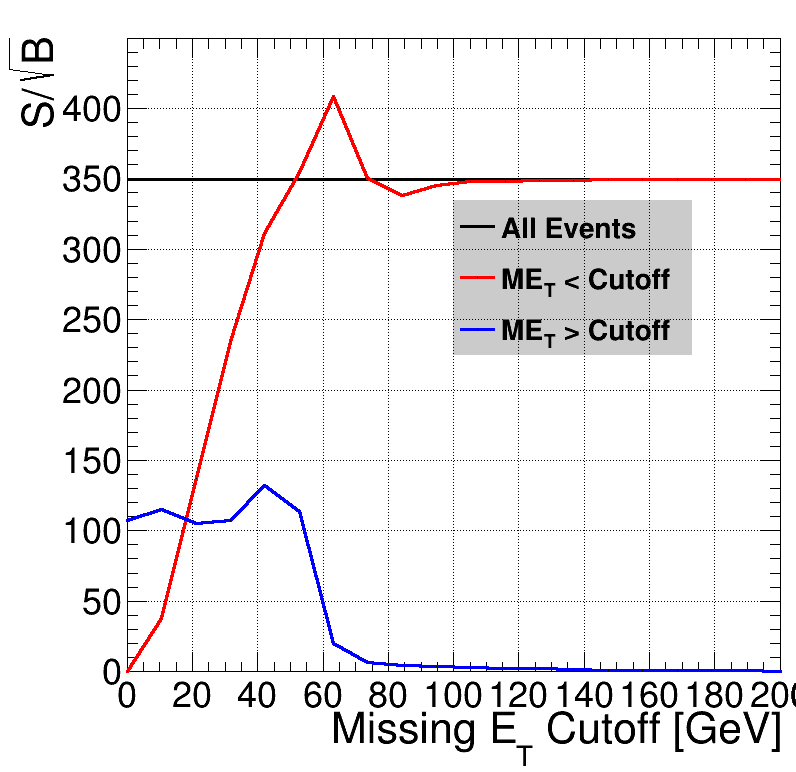

In [46]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()

legend = TLegend(0.57, 0.54, 0.87, 0.74)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.2)

mets = np.array(list(met_abcds.keys())) * 1.0

dphi = np.array([met_abcds[met][0,0] for met in mets])
size = np.array([met_abcds[met][0,1] for met in mets])
s2b = np.array([met_abcds[met][0,2]/(met_abcds[met][0,6]**(1/2)) for met in mets])

dphiL = np.array([met_abcds[met][1,0] for met in mets])
sizeL = np.array([met_abcds[met][1,1] for met in mets])
s2bL = np.array([met_abcds[met][1,2]/(met_abcds[met][1,6]**(1/2)) for met in mets])

dphiH = np.array([met_abcds[met][2,0] for met in mets])
sizeH = np.array([met_abcds[met][2,1] for met in mets])
s2bH = np.array([met_abcds[met][2,2]/(met_abcds[met][2,6]**(1/2)) for met in mets])

# **** #
values, ylabel = [s2b,s2bL,s2bH], 'S/#sqrt{B}'
# values, ylabel = [dphi,dphiL,dphiH], '|#Delta#phi|'
# values, ylabel = [size,sizeL,sizeH], 'DT N Hits'

xlabel = 'Missing E_{T} Cutoff [GeV]'
names = ['All Events', 'ME_{T} < Cutoff', 'ME_{T} > Cutoff']
hmin, hmax = 0, np.max(values)*1.1
for igr, val in enumerate(values):
    gr = TGraph(len(mets),mets,val)
    gr.GetXaxis().SetLimits(np.min(mets), np.max(mets))
    gr.SetMinimum(hmin)
    gr.SetMaximum(hmax)
    gr.SetName(names[igr])
    gr.GetXaxis().SetTitle(xlabel)
    gr.GetYaxis().SetTitle(ylabel)

    gr.SetLineWidth(3)
    gr.SetLineColor(SCL[igr])
    gr.Draw(('' if igr else 'A')+' LP')
    legend.AddEntry(gr,gr.GetName(),'LP')
    gc.append(gr)

legend.Draw()
canvas.Draw()

In [47]:
mets[np.argmax(s2bL*s2bH)]

42.10526315789474